In [1]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


In [2]:
os.listdir()


['.git',
 'Bitcoin.zip',
 'BTC-INR.csv',
 'BTC-USD.csv',
 'BTC_predictions.png',
 'BTC_validation.png',
 'main.py',
 'README.md']

In [3]:
df = pd.read_csv("BTC-USD.csv")


In [4]:
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2.422000e+03
mean,7222.063690,7424.075913,7012.698308,7244.783866,7244.783866,1.206688e+10
std,11075.435681,11416.741157,10711.291406,11120.735247,11120.735247,1.902440e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,457.029487,462.521988,453.033508,457.392510,457.392510,6.819998e+07
50%,4167.494873,4309.098632,4047.088012,4168.899902,4168.899902,3.899710e+09
75%,9083.258789,9274.412110,8843.286865,9111.083252,9111.083252,1.808117e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2426 non-null   object 
 1   Open       2422 non-null   float64
 2   High       2422 non-null   float64
 3   Low        2422 non-null   float64
 4   Close      2422 non-null   float64
 5   Adj Close  2422 non-null   float64
 6   Volume     2422 non-null   float64
dtypes: float64(6), object(1)
memory usage: 132.8+ KB


In [6]:
df.isnull().sum()


Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [7]:
df.dropna(axis=0,how='any',inplace=True)


In [8]:
df.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))
# Normalizing/Scaling the Data

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


In [10]:
df.isnull().sum()
df_index = df.index.ravel()
print(df.index)
print(df.columns)
df.shape


DatetimeIndex(['2018-08-09', '2018-08-10', '2018-08-11', '2018-08-12',
               '2018-08-13', '2018-08-14', '2018-08-15', '2018-08-16',
               '2018-08-17', '2018-08-18',
               ...
               '2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02',
               '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
               '2021-05-07', '2021-05-08'],
              dtype='datetime64[ns]', name='Date', length=1000, freq=None)
Index(['Close'], dtype='object')


(1000, 1)

In [11]:
df.isnull().sum()


Close    0
dtype: int64

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2018-08-09 to 2021-05-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


In [13]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Create a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
        

In [14]:
# How many periods looking back to train
n_per_in  = 30

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))


In [15]:
# Instantiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

model.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 12)            1

In [16]:
with tf.device('/GPU:0'):
    res = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1)


Epoch 1/100
27/27 [==============================] - 45s 1s/step - loss: 0.0169 - accuracy: 0.0753 - val_loss: 0.5656 - val_accuracy: 0.0515
Epoch 2/100
27/27 [==============================] - 24s 880ms/step - loss: 0.0125 - accuracy: 0.0665 - val_loss: 0.5238 - val_accuracy: 0.1443
Epoch 3/100
27/27 [==============================] - 23s 855ms/step - loss: 0.0098 - accuracy: 0.1209 - val_loss: 0.4350 - val_accuracy: 0.0722
Epoch 4/100
27/27 [==============================] - 23s 857ms/step - loss: 0.0056 - accuracy: 0.1113 - val_loss: 0.2665 - val_accuracy: 0.0515
Epoch 5/100
27/27 [==============================] - 24s 879ms/step - loss: 0.0029 - accuracy: 0.1448 - val_loss: 0.1381 - val_accuracy: 0.0515
Epoch 6/100
27/27 [==============================] - 23s 863ms/step - loss: 0.0014 - accuracy: 0.1395 - val_loss: 0.0934 - val_accuracy: 0.0619
Epoch 7/100
27/27 [==============================] - 23s 867ms/step - loss: 0.0012 - accuracy: 0.1599 - val_loss: 0.0915 - val_accuracy: 0.

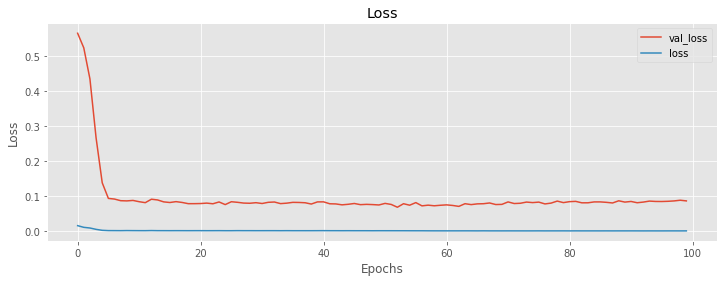

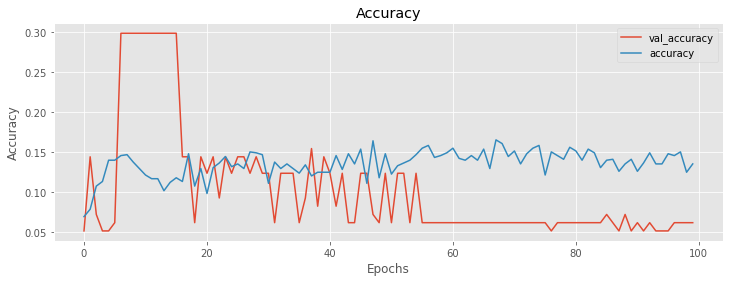

In [17]:
visualize_training_results(res)


Predicted Prices:
 [[36348.27746611924], [36906.38650621473], [37205.92001574284], [36237.972549442624], [36405.9067290965], [36852.75533397447], [36042.094840729325], [36209.50815501316], [35829.118379178544], [35138.921473413466]]

Actual Prices:
 [[53555.109375], [57750.17578099999], [57828.05078099999], [56631.078125], [57200.29296900001], [53333.539063], [57424.007813], [56396.515625], [57356.40234400001], [58211.10546900001]]


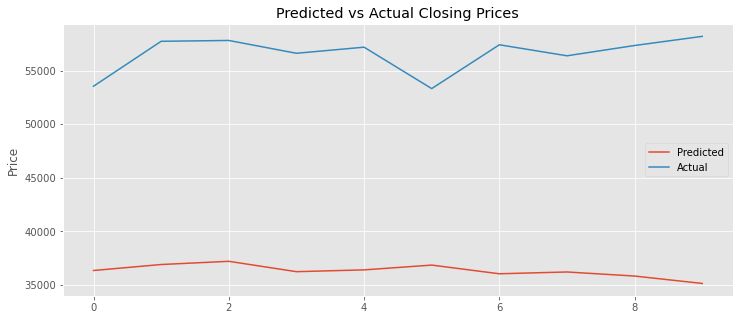

In [18]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()



                   Close
2021-05-08  36350.673447
2021-05-09  36909.048308
2021-05-10  37208.229784
2021-05-11  36240.023681
2021-05-12  36407.832135
2021-05-13  36854.896270
2021-05-14  36043.176085
2021-05-15  36211.146187
2021-05-16  35830.382825
2021-05-17  35140.128444


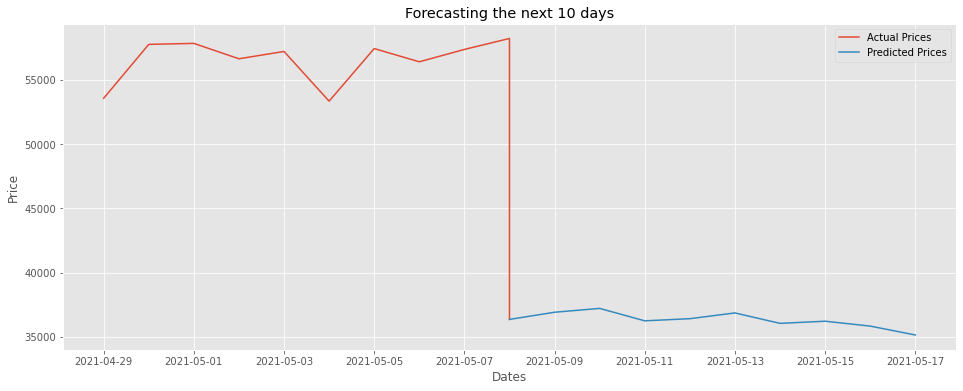

In [19]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()


In [20]:
import pickle
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Pkl_Filename = "bitcoinprice.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(sc, file)
    

In [21]:
from keras.models import model_from_json

bitcoin_model_json = model.to_json()  
with open("bitcoin_model.json", "w") as json_file:  
    json_file.write(bitcoin_model_json)  
model.save_weights("bitcoin_model_weights.h5")
